In [12]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.ar_model import AutoReg
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [26]:
census = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv")
test= pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv",parse_dates=['first_day_of_month'])
train=pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv",parse_dates=["first_day_of_month"])


In [14]:
col = [col for col in census if col.startswith('pct_it')]  
df = census[col];df2 = df[(df == 0).all(axis=1)];df2.reset_index(level=0,inplace=True)


df3 = census['cfips'].to_frame();df3.reset_index(level=0,inplace=True);

df = pd.merge(df3,df2,how ='inner',on ='index');df.set_index(df.columns[0],inplace=True)
df1 = train[['cfips','first_day_of_month','microbusiness_density']]
df = pd.merge(df,df1,how ='inner',on ='cfips')

In [15]:
import plotly.express as px
fig = px.line(df, x='first_day_of_month',y='microbusiness_density',color='cfips')
fig.show()

In [16]:
train[train['microbusiness_density']==0].groupby(['cfips','county','state','microbusiness_density','first_day_of_month','active']).size().to_frame()

0
cfips county           state       microbusiness_density first_day_of_month active   
28055 Issaquena County Mississippi 0.000                 2021-02-01         0       1
                                                         2021-03-01         0       1
                                                         2021-04-01         0       1
                                                         2021-05-01         0       1
                                                         2021-06-01         0       1
                                                         2021-07-01         0       1
                                                         2021-08-01         0       1
                                                         2021-09-01         0       1
                                                         2021-10-01         0       1
                                                         2021-11-01         0       1
                                                         2021-12-01         0       1
                                                         2022-01-01         0       1
                                                         2022-02-01         0       1
                                                         2022-03-01         0       1
                                                         2022-04-01         0       1
                                                         2022-05-01         0       1
                                                         2022-06-01         0       1
                                                         2022-07-01         0       1
                                                         2022-08-01         0       1
                                                         2022-09-01         0       1
                                                         2022-10-01         0       1
48301 Loving County    Texas       0.000                 2020-01-01         0       1
                                                         2020-02-01         0       1
                                                         2020-03-01         0       1
                                                         2021-02-01         0       1
                                                         2021-03-01         0       1

In [28]:
train = train[train["microbusiness_density"]<13]

In [29]:
train.shape

(118889, 7)

In [18]:
test = pd.merge(test, census, how="left", on="cfips")
train = pd.merge(train, census, how="left", on="cfips")

<AxesSubplot:>

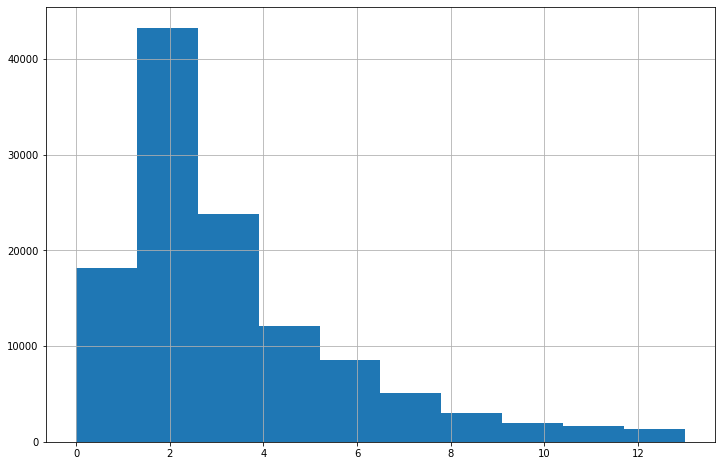

In [19]:
train["microbusiness_density"].hist(figsize=(12,8))

In [20]:
def create_date_features(df):
    df['month'] = df.first_day_of_month.dt.month
    df['day_of_month'] = df.first_day_of_month.dt.day
    df['day_of_year'] = df.first_day_of_month.dt.dayofyear
    df['week_of_year'] = df.first_day_of_month.dt.weekofyear
    df['day_of_week'] = df.first_day_of_month.dt.dayofweek
    df['year'] = df.first_day_of_month.dt.year
    df["is_wknd"] = df.first_day_of_month.dt.weekday // 4
    df['is_month_start'] = df.first_day_of_month.dt.is_month_start.astype(int)
    df['is_month_end'] = df.first_day_of_month.dt.is_month_end.astype(int)
    return df

train = create_date_features(train)
test=create_date_features(test)

In [21]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [22]:
X = train.drop(columns={"row_id", "first_day_of_month", "microbusiness_density", "county", "state", "active"})
y = train["microbusiness_density"]

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

x_pred = test.drop(columns={"row_id", "first_day_of_month"})

In [23]:
model = XGBRegressor(n_estimators=4000, eval_metric=smape, early_stopping_rounds=30, learning_rate=0.1)
model.fit(x_train, y_train,  
             eval_set=[(x_valid, y_valid)],
             verbose=100)

y_pred = model.predict(x_pred)

[0]	validation_0-rmse:3.38713	validation_0-smape:105.34099
[100]	validation_0-rmse:0.71217	validation_0-smape:18.66778
[200]	validation_0-rmse:0.50899	validation_0-smape:13.09278
[300]	validation_0-rmse:0.40707	validation_0-smape:9.96286
[400]	validation_0-rmse:0.35103	validation_0-smape:8.17189
[500]	validation_0-rmse:0.31498	validation_0-smape:6.96273
[600]	validation_0-rmse:0.29380	validation_0-smape:6.23898
[700]	validation_0-rmse:0.27864	validation_0-smape:5.80970
[800]	validation_0-rmse:0.26500	validation_0-smape:5.37755
[900]	validation_0-rmse:0.25601	validation_0-smape:5.06856
[1000]	validation_0-rmse:0.24861	validation_0-smape:4.81113
[1100]	validation_0-rmse:0.24292	validation_0-smape:4.62344
[1200]	validation_0-rmse:0.23829	validation_0-smape:4.46554
[1300]	validation_0-rmse:0.23408	validation_0-smape:4.32846
[1400]	validation_0-rmse:0.23054	validation_0-smape:4.21321
[1500]	validation_0-rmse:0.22791	validation_0-smape:4.10956
[1600]	validation_0-rmse:0.22559	validation_0-sm

KeyboardInterrupt: 

In [ ]:
test["microbusiness_density"] = pd.Series(y_pred).astype(float)
test[["row_id", "microbusiness_density"]].to_csv("submission.csv", index=False)